# Import Libraries

In [269]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import re
import matplotlib.pyplot as plt
import warnings
import string
warnings.filterwarnings("ignore", category=FutureWarning)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Import The Dataset

The data processed contains the the training data, validation data, and test data (with unmasked and masked label) that has been preprocessed. However, later on, we will further preprocess the code to increase the accuracy.

In [270]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [271]:
df_train = pd.read_csv("drive/MyDrive/sentiment-prosa/train_preprocess.tsv", sep='\t', header=None)
df_valid = pd.read_csv("drive/MyDrive/sentiment-prosa/valid_preprocess.tsv", sep='\t', header=None)
df_test_unmasked = pd.read_csv("drive/MyDrive/sentiment-prosa/test_preprocess.tsv", sep='\t', header=None)
df_test_masked = pd.read_csv("drive/MyDrive/sentiment-prosa/test_preprocess_masked_label.tsv", sep='\t', header=None)

Open the vocabulary document

In [272]:
with open('drive/MyDrive/sentiment-prosa/vocab_uncased.txt', 'r') as f:
    vocab = f.read().splitlines()

In [273]:
df_train.columns = ["text", "emotion"]
df_valid.columns = ["text", "emotion"]
df_test_unmasked.columns = ["text", "emotion"]
df_test_masked.columns = ["text", "emotion"]

df_train.head(10)

,text,emotion
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
5,"makanan beragam , harga makanan di food stall ...",positive
6,pakai kartu kredit bca tidak untung malah rugi...,negative
7,"tempat unik , bagus buat foto , makanan enak ,...",positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


# Pre-processing

## Remove punctuation and numbers

In [274]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', text)

In [275]:
df_train['text'] = df_train['text'].apply(remove_punctuation)
df_valid['text'] = df_valid['text'].apply(remove_punctuation)
df_test_unmasked['text'] = df_test_unmasked['text'].apply(remove_punctuation)
df_test_masked['text'] = df_test_masked['text'].apply(remove_punctuation)

vocab_filtered = []

for word in vocab:
  word_filtered = remove_punctuation(word)
  vocab_filtered.append(word_filtered)

## Stop words removal and tokenization

In [276]:
# Set stopwords
stop_words = set(stopwords.words('indonesian'))

def tokenize_text(text):
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply tokenization to the train, validation, and test datasets
df_train['text'] = df_train['text'].apply(tokenize_text)
df_valid['text'] = df_valid['text'].apply(tokenize_text)
df_test_unmasked['text'] = df_test_unmasked['text'].apply(tokenize_text)

In [277]:
df_train.head(10)

,text,emotion
0,warung dimiliki pengusaha pabrik puluhan terke...,positive
1,mohon ulama lurus k mmbri hujjah partai diwlh ...,neutral
2,lokasi strategis jalan sumatera bandung nya ny...,positive
3,betapa bahagia nya unboxing paket barang nya b...,positive
4,duh mahasiswa sombong kasih kartu kuning belaj...,negative
5,makanan beragam harga makanan food stall kasir...,positive
6,pakai kartu kredit bca untung rugi,negative
7,unik bagus foto makanan enak pegawai ramah ber...,positive
8,keluarga menikmati pengalaman kuliner menyenan...,positive
9,bersyukur,positive


In [278]:
df_test_unmasked.head(10)

,text,emotion
0,kemarin gue makan dago gue makanan nya enak ha...,negative
1,kayak nya sih gue gila ya gue ngerti nya dibia...,negative
2,dipikir pikir dibanggakan jokowi nepatin janji...,negative
3,kalinya gua bank ngurusin pembuatan rekening n...,negative
4,gue disuruh latihan karate nya biar gue melawa...,negative
5,pelayanan hotel salak bogor sebagus gue membay...,negative
6,young lex mengirim berfaedah kayak gitu merusa...,negative
7,gue pesimis manusia ngurusin sampah hewan hewa...,negative
8,kecewa pengeditan biodata penumpang by sistem ...,negative
9,pemesanan tiket kunjung terima menelpon pelaya...,negative


# Exploratory Data Analysis

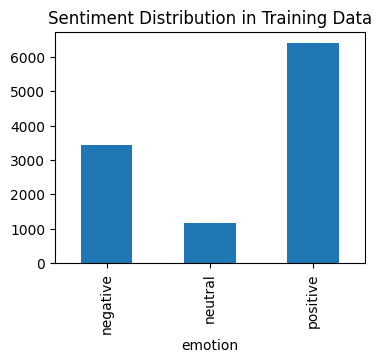

,text
emotion,
negative,3436
neutral,1148
positive,6416


In [279]:
fig = plt.figure(figsize=(4,3))
df_train.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Sentiment Distribution in Training Data")
plt.show()
df_train.groupby('emotion').text.count()

In [280]:
# Encoding emotions
emotion_encoding = {'negative': 0, 'neutral': 1, 'positive': 2}

df_train['emotion'] = df_train['emotion'].replace(emotion_encoding)
df_valid['emotion'] = df_valid['emotion'].replace(emotion_encoding)
df_test_unmasked['emotion'] = df_test_unmasked['emotion'].replace(emotion_encoding)
df_test_masked['emotion'] = df_test_masked['emotion'].replace(emotion_encoding)

# Experiment 1: Linear Kernel

## Training

In [281]:
# Create a bag of words from the vocab_uncased.txt
cleaned_vocab = [string.strip() for string in vocab_filtered if string.strip()]
cleaned_vocab = list(dict.fromkeys(cleaned_vocab))
vectorizer = CountVectorizer(vocabulary=cleaned_vocab)

# Extract training, validation, and test data into each array and transform using vocabulary
X_train = vectorizer.transform(df_train['text'])
y_train = df_train['emotion']
X_valid = vectorizer.transform(df_valid['text'])
y_valid = df_valid['emotion']
X_test = vectorizer.transform(df_test_unmasked['text'])
y_test = df_test_unmasked['emotion']

In [282]:
# Create SVM model with selected experiment kernel and train
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Do validation
y_valid_pred = svm_model.predict(X_valid)

## Evaluate training model

In [283]:
def class_report_valid(y_valid, y_valid_pred):
  # Evaluate using metrics
  accuracy = accuracy_score(y_valid, y_valid_pred)
  precision = precision_score(y_valid, y_valid_pred, average='macro')
  recall = recall_score(y_valid, y_valid_pred, average='macro')
  f1 = f1_score(y_valid, y_valid_pred, average='macro')

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-Score: {f1}')

  # Print classification report
  print(classification_report(y_valid, y_valid_pred, target_names=['negative', 'neutral', 'positive']))

def class_report_test(y_test, y_test_pred):
  accuracy_test = accuracy_score(y_test, y_test_pred)
  precision_test = precision_score(y_test, y_test_pred, average='macro')
  recall_test = recall_score(y_test, y_test_pred, average='macro')
  f1_test = f1_score(y_test, y_test_pred, average='macro')

  print(f'Test Accuracy: {accuracy_test}')
  print(f'Test Precision: {precision_test}')
  print(f'Test Recall: {recall_test}')
  print(f'Test F1-Score: {f1_test}')

In [284]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.8293650793650794
Precision: 0.8038126870464487
Recall: 0.7658934404673379
F1-Score: 0.7802395162308956
              precision    recall  f1-score   support

    negative       0.74      0.82      0.78       394
     neutral       0.78      0.60      0.68       131
    positive       0.89      0.87      0.88       735

    accuracy                           0.83      1260
   macro avg       0.80      0.77      0.78      1260
weighted avg       0.83      0.83      0.83      1260



In [285]:
# Predict x column using SVM model
y_test_pred = svm_model.predict(X_test)

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.71
Test Precision: 0.697164438936591
Test Recall: 0.6658153937565703
Test F1-Score: 0.6757216296480278
Banyak data yang salah diprediksi: 145


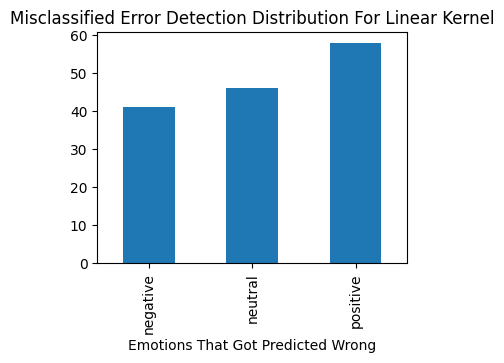

,text
emotion,
negative,41
neutral,46
positive,58


In [286]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For Linear Kernel")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()

# Experiment 2: RBF Kernel

## Training

In [287]:
# Create SVM model with selected experiment kernel and train
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

# Do validation
y_valid_pred = svm_model.predict(X_valid)

## Evaluate training model

In [288]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.8444444444444444
Precision: 0.8447012965318385
Recall: 0.7360940408247618
F1-Score: 0.7634555283672672
              precision    recall  f1-score   support

    negative       0.73      0.86      0.79       394
     neutral       0.89      0.44      0.59       131
    positive       0.91      0.91      0.91       735

    accuracy                           0.84      1260
   macro avg       0.84      0.74      0.76      1260
weighted avg       0.85      0.84      0.84      1260



In [289]:
# Predict x column using SVM model
y_test_pred = svm_model.predict(X_test)

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.664
Test Precision: 0.7238460601631957
Test Recall: 0.5662735956853604
Test F1-Score: 0.5591094545745384
Banyak data yang salah diprediksi: 168


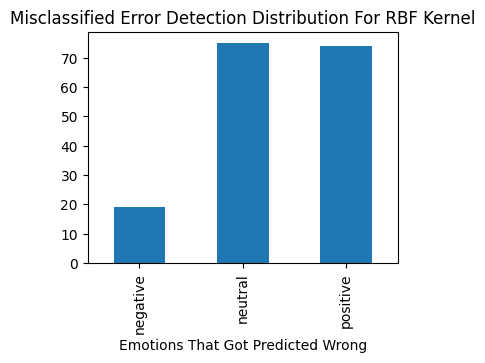

,text
emotion,
negative,19
neutral,75
positive,74


In [290]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For RBF Kernel")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()

# Experiment 3: Poly Kernel

## Training

In [291]:
# Create SVM model with selected experiment kernel and train
svm_model = SVC(kernel='poly')
svm_model.fit(X_train, y_train)

# Do validation
y_valid_pred = svm_model.predict(X_valid)

## Evaluate training model

In [292]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.6714285714285714
Precision: 0.8094591085428903
Recall: 0.5311212649769741
F1-Score: 0.4796139390738847
              precision    recall  f1-score   support

    negative       0.49      0.93      0.64       394
     neutral       1.00      0.02      0.03       131
    positive       0.94      0.65      0.77       735

    accuracy                           0.67      1260
   macro avg       0.81      0.53      0.48      1260
weighted avg       0.81      0.67      0.65      1260



In [293]:
# Predict x column using SVM model
y_test_pred = svm_model.predict(X_test)

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.456
Test Precision: 0.4255834577033721
Test Recall: 0.3716691804927099
Test F1-Score: 0.2761634438391121
Banyak data yang salah diprediksi: 272


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


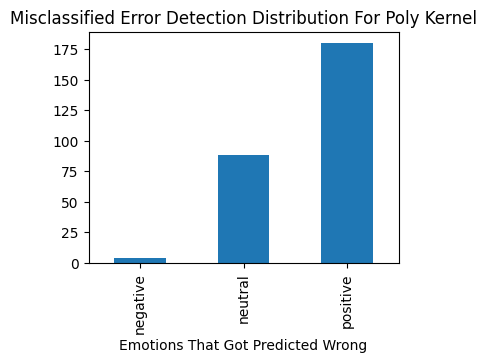

,text
emotion,
negative,4
neutral,88
positive,180


In [294]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For Poly Kernel")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()

# Experiment 4: Hyperparameter tuning

In [295]:
# Do hyperparameter tuning
parameters = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10, 20]}
# Use grid search
grid_search = GridSearchCV(SVC(), parameters, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'C': 10, 'kernel': 'rbf'}


## Training

In [296]:
# Create SVM model with selected experiment kernel and train
svm_model = SVC(kernel='rbf', C=10)
svm_model.fit(X_train, y_train)

# Do validation
y_valid_pred = svm_model.predict(X_valid)

## Evaluate training model

In [297]:
def class_report_valid(y_valid, y_valid_pred):
  # Evaluate using metrics
  accuracy = accuracy_score(y_valid, y_valid_pred)
  precision = precision_score(y_valid, y_valid_pred, average='macro')
  recall = recall_score(y_valid, y_valid_pred, average='macro')
  f1 = f1_score(y_valid, y_valid_pred, average='macro')

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-Score: {f1}')

  # Print classification report
  print(classification_report(y_valid, y_valid_pred, target_names=['negative', 'neutral', 'positive']))

def class_report_test(y_test, y_test_pred):
  accuracy_test = accuracy_score(y_test, y_test_pred)
  precision_test = precision_score(y_test, y_test_pred, average='macro')
  recall_test = recall_score(y_test, y_test_pred, average='macro')
  f1_test = f1_score(y_test, y_test_pred, average='macro')

  print(f'Test Accuracy: {accuracy_test}')
  print(f'Test Precision: {precision_test}')
  print(f'Test Recall: {recall_test}')
  print(f'Test F1-Score: {f1_test}')

In [298]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.846031746031746
Precision: 0.8295699769434589
Recall: 0.7772442253402568
F1-Score: 0.7982707570156701
              precision    recall  f1-score   support

    negative       0.78      0.80      0.79       394
     neutral       0.83      0.62      0.71       131
    positive       0.89      0.91      0.90       735

    accuracy                           0.85      1260
   macro avg       0.83      0.78      0.80      1260
weighted avg       0.85      0.85      0.84      1260



In [299]:
# Predict x column using SVM model
y_test_pred = svm_model.predict(X_test)

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.716
Test Precision: 0.6930278226108442
Test Recall: 0.6597593582887701
Test F1-Score: 0.6688967451379398
Banyak data yang salah diprediksi: 142


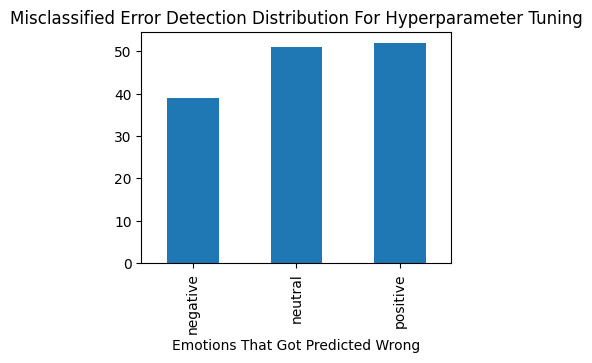

,text
emotion,
negative,39
neutral,51
positive,52


In [300]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For Hyperparameter Tuning")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()